# Random Forest
Total dataset size: 134 samples <br>
Training set: 134 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA_PET_mm
- Aridity idx
- NDVI
- LTA soil moisture - 10 cm (m3 m-3) 

In [28]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates
import json
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import haversine_distances
from math import radians

# Prepare all BGS points as training points

# read file (data + coordinates)
file = pd.read_csv('Data/Low_res_data_05/input_05_ext.csv')
# OMIT ZERO RECHARGE SAMPLES - comment if zero-recharge sites should be included
#file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa']< 800]
# drop unimportant columns
data = file.drop(columns=['ID', 'Lat', 'Long', 'Aquifer_group', 'Soil_group', 'Landcover', 'Landcover_NOAA','Landcover_GlobCover','LTA_GPCC_mmpa', 'LTA_CHIRPS_mmpa', 'SM10_kgm2', 'LTA_WD_days', 'DEM'])
# Labels are the values we want to predict
labels = np.log10(data['Recharge_mmpa'])
#labels = data['Recharge_mmpa']
data = data.drop('Recharge_mmpa', axis = 1)
# Add for reference
data['ID'] = file['ID']
# Convert to numpy array

# Saving feature names for later use
feature_list = list(data.columns)
features = np.array(data)

data

,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,ID
0,1234.743356,1265.000000,0.977426,0.548899,0.317942,1
1,555.876675,1386.030028,0.403442,0.417538,0.210401,2
2,1376.716688,1337.440024,1.029575,0.687945,0.312940,3
3,518.196676,1590.610029,0.326188,0.268559,0.229384,4
4,1344.580024,1298.693353,1.038857,0.593882,0.330358,5
...,...,...,...,...,...,...
129,655.280013,1356.070025,0.486649,0.403724,0.323871,130
130,816.720013,1266.233355,0.648767,0.479056,0.227937,131
131,510.140009,1922.536704,0.265403,0.327490,0.194245,132
132,1215.073356,1149.026683,1.058098,0.447078,0.279276,133


In [2]:
correlation_matrix = data.corr()
correlation_matrix

,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,ID
LTA_P_mmpa,1.000000,-0.587859,0.974247,0.859306,0.938423,0.002121
LTA_PET_mm,-0.587859,1.000000,-0.657775,-0.733611,-0.635865,-0.026746
Aridity,0.974247,-0.657775,1.000000,0.851722,0.928455,-0.002271
NDVI,0.859306,-0.733611,0.851722,1.000000,0.833622,0.020414
SM10_m3m3,0.938423,-0.635865,0.928455,0.833622,1.000000,0.036649
ID,0.002121,-0.026746,-0.002271,0.020414,0.036649,1.000000


# Run RF for the whole domain

In [3]:
# get all coordinates of the smallest raster - workaround as rasters have slightly different shapes
coords, T0, out_shape = getAllCoordinates('Data/Low_res_data_05/LTA_AnnPrecip_Afr_05.tif')
coords_np = np.array([*coords])

In [4]:
# read rasters
pet_src = rasterio.open('Data/Low_res_data_05/LTA_AnnPET_Afr_05.tif')
p_src = rasterio.open('Data/Low_res_data_05/LTA_AnnPrecip_Afr_05.tif')
ndvi_src = rasterio.open('Data/Low_res_data_05/LTA_NDVI_Afr_05.tif')
ai_src = rasterio.open('Data/Low_res_data_05/LTA_aridity_index_Afr_05.tif')
sm_src = rasterio.open('Data/Low_res_data_05/LTA_FLDAS_soil_moisture_Afr_05.tif')

# get raster values at 0.5x0.5 grid + flatten
pet_samples = [item for sublist in list(pet_src.sample(coords)) for item in sublist]
p_samples = [item for sublist in list(p_src.sample(coords)) for item in sublist]
ndvi_samples = [item for sublist in list(ndvi_src.sample(coords)) for item in sublist]
ai_samples = [item for sublist in list(ai_src.sample(coords)) for item in sublist]
sm_samples = [item for sublist in list(sm_src.sample(coords)) for item in sublist]

In [5]:
# combine predictors in a dataframe
raw_ds = pd.DataFrame({'LTA_P_mmpa': p_samples, 'LTA_PET_mm': pet_samples,
                       'Aridity': ai_samples, 'NDVI': ndvi_samples,
                       'SM10_m3m3': sm_samples, 'Lat': coords_np[:,0], 'Lon': coords_np[:,1]})

# take rows with valid predictor data (land only)
filtered_ds = raw_ds[(raw_ds['LTA_P_mmpa'] >= -1000)
                     & (raw_ds['LTA_PET_mm'] >= -1000) & (raw_ds['Aridity'] >= -1000) 
                     & (raw_ds['SM10_m3m3'] > 0) & (raw_ds['NDVI'] >= -1000)]

# hyperparam optimization - see Pred_importance_analysis.ipynb
params = {'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 0.33,
 'max_depth': 80,
 'bootstrap': True}

# optimised hyperparameters for RF with zero-recharge points
# params = {'n_estimators': 2000,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 0.33,
#  'max_depth': 10,
#  'bootstrap': True}

In [6]:
# convert dataframe to numpy array
domain_features = np.array(filtered_ds)[:,:-2]
domain_features

array([[6.16320007e+02, 1.17996338e+03, 5.23716927e-01, 6.67900383e-01,
        2.83147454e-01],
       [6.02160034e+02, 1.23114001e+03, 4.90119904e-01, 5.97497880e-01,
        2.52911627e-01],
       [6.64390015e+02, 1.26000330e+03, 5.28561354e-01, 5.29737592e-01,
        2.65965372e-01],
       ...,
       [6.44410034e+02, 1.11967004e+03, 5.78621864e-01, 5.45690835e-01,
        2.35114634e-01],
       [4.63203339e+02, 1.08768665e+03, 4.28617209e-01, 5.10673344e-01,
        2.36798123e-01],
       [4.92330017e+02, 1.14116333e+03, 4.34005886e-01, 4.67423260e-01,
        2.23894745e-01]])

In [7]:
# instantiate random forest model
final_rf = RandomForestRegressor(**params, oob_score=True)
# train the model on entire BGS dataset
final_rf.fit(features[:,:-1], labels)
# use the forest's predict method on the whole domain
pred_recharge = final_rf.predict(domain_features)
# apply to training set again
train_predictions = final_rf.predict(features[:,:-1])

In [8]:
print(f'OOB score {final_rf.oob_score_}')

OOB score 0.7575342106043622


In [9]:
# merge with the features dataframe and back transform
filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge
# fill gaps in the dataframe - revert to 0.5x0.5 grid
reindx_ds = filtered_ds.reindex(range(len(raw_ds)), fill_value=-9999)
recharge_grid = np.array(reindx_ds['pred_recharge_mmpa']).reshape(out_shape)

# attempt to save to a raster
# config
out_meta = {'driver': 'GTiff', "dtype": 'float32', "height": recharge_grid.shape[0], "width": recharge_grid.shape[1],
            "transform": T0, 'nodata': -9999, 'crs': rasterio.crs.CRS({"init": "epsg:4326"})}

# save
with rasterio.open("Data/Low_res_data_05/RF_recharge.tif", "w", **out_meta, count=1) as dest:
#with rasterio.open("Data/Low_res_data_05/RF_recharge_zero.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid[np.newaxis, :, :])

<ipython-input-9-6d8c61b56b82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge


In [10]:
# Get numerical feature importances
importances = list(final_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most Aimportant first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: LTA_P_mmpa           Importance: 0.24
Variable: SM10_m3m3            Importance: 0.23
Variable: Aridity              Importance: 0.22
Variable: NDVI                 Importance: 0.19
Variable: LTA_PET_mm           Importance: 0.13


In [11]:
print(f'Max predicted recharge: {10**np.max(pred_recharge)}')

Max predicted recharge: 276.3122292454795


In [12]:
# report R-squared based on fivefold cross validation
print(f'R-squared based on fivefold cross-validation: {np.mean(cross_val_score(final_rf, features[:,:-1], labels, cv=5))}')

R-squared based on fivefold cross-validation: 0.7415047032113689


## Result comparison
- random forest (RF)
- random forest with residual kriging (RK RF) - combined in R
- linear mixed model by MacDonald et al 2021 - BGS (LMM)

In [13]:
# compare LMM and random forest results
point_coords = [(i,j) for (i,j) in zip(file['Long'], file['Lat'])]
rech_obs = file['Recharge_mmpa']
p_samples = file['LTA_P_mmpa']
ai_samples = file['Aridity']
rf_rech_src = rasterio.open('Data/Low_res_data_05/RF_recharge.tif')
rf_rech_zeros_src = rasterio.open('Data/Low_res_data_05/RF_recharge_zero.tif')
rk_rf_rech_src = rasterio.open('Data/Low_res_data_05/R_RKRF_recharge_05.tif')
bgs_rech_src = rasterio.open('Data/Low_res_data_05/BGS_Africa_recharge_05.tif')

rk_rf_z_rech_src = rasterio.open('Data/Low_res_data_05/RK_RF_recharge_zero.tif')

rf_rech_samples = [item for sublist in list(rf_rech_src.sample(point_coords, indexes=1)) for item in sublist]
rf_rech_zeros_samples = [item for sublist in list(rf_rech_zeros_src.sample(point_coords, indexes=1)) for item in sublist]
rk_rf_rech_samples = [item for sublist in list(rk_rf_rech_src.sample(point_coords, indexes=1)) for item in sublist]
bgs_rech_samples = [item for sublist in list(bgs_rech_src.sample(point_coords)) for item in sublist]

rk_rf_z_rech_samples = [item for sublist in list(rk_rf_z_rech_src.sample(point_coords)) for item in sublist]

summary = pd.DataFrame({'Lon': file['Long'], 'Lat': file['Lat'], 'Observations': rech_obs,'RF': rf_rech_samples, 
                        'RF (zeros)': rf_rech_zeros_samples, 'RK_RF': rk_rf_rech_samples, 
                        'RK_RF (zeros)': rk_rf_z_rech_samples, 'LMM': bgs_rech_samples})

summary.index.names = ['ID']
summary.index += 1
print(summary)
#summary.to_csv("summary_05.csv")

       Lon    Lat       Precip   Aridity  Observations          RF  \
ID                                                                   
1     4.48   8.49  1234.743356  0.977426         253.0  184.192230   
2    30.09 -20.27   555.876675  0.403442          22.0   21.484707   
3    32.96   0.46  1376.716688  1.029575         245.0  147.401276   
4    39.82  13.54   518.196676  0.326188         185.0   42.324726   
5     2.30   6.50  1344.580024  1.038857         120.0  176.967834   
..     ...    ...          ...       ...           ...         ...   
130  27.70 -26.00   655.280013  0.486649         100.0   71.841530   
131  30.55 -17.71   816.720013  0.648767          80.0   83.994362   
132 -17.00  14.72   510.140009  0.265403           8.0   19.895945   
133  38.64   9.40  1215.073356  1.058098         160.0  150.552597   
134  33.74  -5.96   555.313341  0.398908          41.0   57.517185   

     RF (zeros)       RK_RF  RK_RF (zeros)           LMM  
ID                            

In [14]:
# problem: some observations are outside of the domain!
print(summary[(summary['LMM'] < 0) | (summary['RF'] < 0)])
# ignore these point for now
summary = summary[(summary['LMM'] >= 0) & (summary['RF'] >= 0)]
# R2 applied to log recharge!
print('\nR squared')
print('LMM vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['LMM'].values)))
print('RF vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RF'].values)))
print('RF (zeros) vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RF (zeros)'].values)))
print('RK RF vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RK_RF'].values)))

print('RF vs LMM R^2:', metrics.r2_score(np.log10(summary['RF'].values), np.log10(summary['LMM'].values)))
print('RK RF vs LMM R^2:', metrics.r2_score(np.log10(summary['RK_RF'].values), np.log10(summary['LMM'].values)))

       Lon    Lat      Precip   Aridity  Observations           RF  \
ID                                                                   
82  -17.29  14.77  512.086674  0.275570          22.0    15.135691   
89   11.03  37.04  571.236677  0.260000          12.0 -9999.000000   
108  18.12 -32.95  256.140005  0.175038          26.0    11.467056   
132 -17.00  14.72  510.140009  0.265403           8.0    19.895945   

      RF (zeros)         RK_RF  RK_RF (zeros)           LMM  
ID                                                           
82     15.782721  1.446229e+01      14.222162 -3.402823e+38  
89  -9999.000000 -3.400000e+38   -9999.000000 -3.402823e+38  
108    11.590491  1.233021e+01       9.806588 -3.402823e+38  
132    19.285196  1.790160e+01      15.766924 -3.402823e+38  

R squared
LMM vs obs R^2: 0.852708187891753
RF vs obs R^2: 0.8690406631194045
RF (zeros) vs obs R^2: 0.8940379199771055
RK RF vs obs R^2: 0.8371879578377065
RF vs LMM R^2: 0.9452628081106638
RK RF vs LMM R^

(0.0, 1000.0)

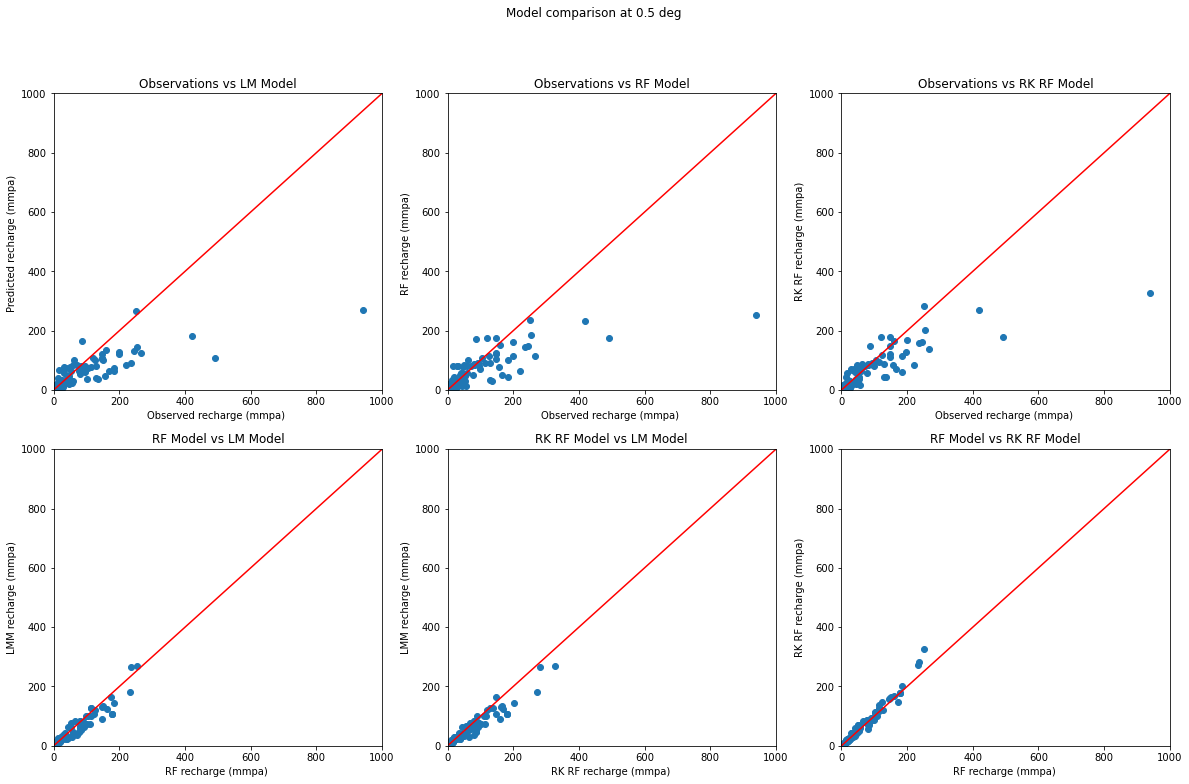

In [15]:
fig, axs = plt.subplots(2,3, figsize=(20,12))
fig.suptitle('Model comparison at 0.5 deg')
axs = axs.flatten()
axs[0].plot(summary['Observations'], summary['LMM'],marker='o',linestyle='')
axs[0].plot(range(0,1000), range(0,1000), 'r')
axs[0].set_xlabel('Observed recharge (mmpa) ')
axs[0].set_ylabel('Predicted recharge (mmpa) ')
axs[0].set_xlim([0,1000])
axs[0].set_title('Observations vs LM Model')
axs[0].set_ylim([0,1000])

axs[1].plot(summary['Observations'], summary['RF'],marker='o',linestyle='')
axs[1].plot(range(0,1000), range(0,1000), 'r')
axs[1].set_xlabel('Observed recharge (mmpa) ')
axs[1].set_ylabel('RF recharge (mmpa) ')
axs[1].set_xlim([0,1000])
axs[1].set_title('Observations vs RF Model')
axs[1].set_ylim([0,1000])

axs[2].plot(summary['Observations'], summary['RK_RF'],marker='o',linestyle='')
axs[2].plot(range(0,1000), range(0,1000), 'r')
axs[2].set_xlabel('Observed recharge (mmpa) ')
axs[2].set_ylabel('RK RF recharge (mmpa)')
axs[2].set_xlim([0,1000])
axs[2].set_title('Observations vs RK RF Model')
axs[2].set_ylim([0,1000])

axs[3].plot(summary['RF'], summary['LMM'],marker='o',linestyle='')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_xlabel('RF recharge (mmpa) ')
axs[3].set_ylabel('LMM recharge (mmpa)')
axs[3].set_xlim([0,1000])
axs[3].set_title('RF Model vs LM Model')
axs[3].set_ylim([0,1000])

axs[4].plot(summary['RK_RF'], summary['LMM'],marker='o',linestyle='')
axs[4].plot(range(0,1000), range(0,1000), 'r')
axs[4].set_xlabel('RK RF recharge (mmpa) ')
axs[4].set_ylabel('LMM recharge (mmpa)')
axs[4].set_xlim([0,1000])
axs[4].set_title('RK RF Model vs LM Model')
axs[4].set_ylim([0,1000])

axs[5].plot(summary['RF'], summary['RK_RF'],marker='o',linestyle='')
axs[5].plot(range(0,1000), range(0,1000), 'r')
axs[5].set_xlabel('RF recharge (mmpa) ')
axs[5].set_ylabel('RK RF recharge (mmpa)')
axs[5].set_xlim([0,1000])
axs[5].set_title('RF Model vs RK RF Model')
axs[5].set_ylim([0,1000])

# Prediction intervals with Quantile Regression Forest (QRF)

During prediction, Random Forest algorithm returns E(Y|X) at each grid cell, which can be interpreted as the answer to the question, what is the expected value of the output given the input at a given point? QRF extends this capability to predict quantiles of the response variable distribution, which can be used to construct prediction intervals

In [16]:
from quantile_forest import RandomForestQuantileRegressor

# Train the QRF model with the same parameters as RF
qrf_model = RandomForestQuantileRegressor(**params)
qrf_model.fit(features[:,:-1], labels)

qrf_predictions = qrf_model.predict(features[:,:-1], quantiles=[0.05, 0.5, 0.95])

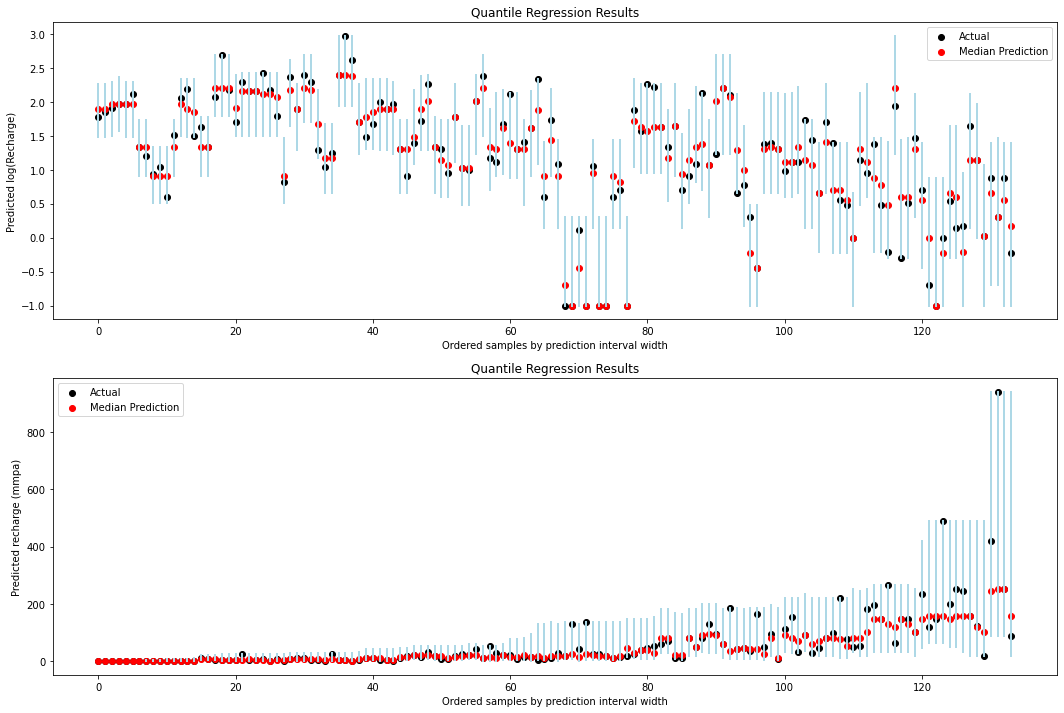

In [17]:
lower_quantile_pred = qrf_predictions[:,0]  # 0.025 quantile
median_pred = qrf_predictions[:,1]        # 0.5 quantile
upper_quantile_pred = qrf_predictions[:,2] # 0.975 quantile

prediction_interval_width = upper_quantile_pred - lower_quantile_pred

# Sort the samples based on the width of prediction interval
sorted_indices = np.argsort(prediction_interval_width)

plt.figure(figsize=(18, 12))

# Create the first plot on log scale
plt.subplot(2, 1, 1)

# Plot the actual labels
plt.scatter(np.arange(0, 134), labels[sorted_indices], color='black', label='Actual')

# Plot the median predictions
plt.scatter(np.arange(0, 134), median_pred[sorted_indices], color='red', label='Median Prediction')

# Plot the prediction intervals as boxes
for i, index in enumerate(sorted_indices):
    plt.plot([i, i], [lower_quantile_pred[index], upper_quantile_pred[index]], color='lightblue', linewidth=2)


# Add labels and legend
plt.xlabel('Ordered samples by prediction interval width')
plt.ylabel('Predicted log(Recharge)')
plt.legend()
plt.title('Quantile Regression Results')

# Create the second plot, backtransformed
plt.subplot(2, 1, 2)

prediction_interval_width = 10**upper_quantile_pred - 10**lower_quantile_pred
sorted_indices = np.argsort(prediction_interval_width)

plt.scatter(np.arange(0, 134), 10**labels[sorted_indices], color='black', label='Actual')
plt.scatter(np.arange(0, 134), 10**median_pred[sorted_indices], color='red', label='Median Prediction')

for i, index in enumerate(sorted_indices):
    plt.plot([i, i], [10**lower_quantile_pred[index], 10**upper_quantile_pred[index]], color='lightblue', linewidth=2)

# Add labels and legend
plt.xlabel('Ordered samples by prediction interval width')
plt.ylabel('Predicted recharge (mmpa)')
plt.legend()
plt.title('Quantile Regression Results')

# Show plot
plt.show()

In [18]:
# coverage fraction
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


coverage_fraction(labels,
                  qrf_predictions[:,0],
                  qrf_predictions[:,2])

1.0

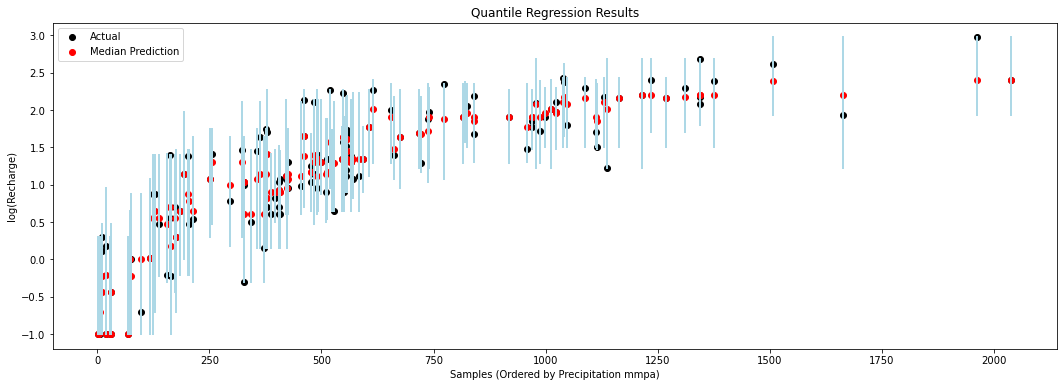

In [19]:
# Sort the samples based on the width of prediction interval
sorted_indices = np.argsort(features[:,0])

# Set a wider figure size
plt.figure(figsize=(18, 6))  # Adjust the width and height as needed

# Plot the actual labels
plt.scatter(features[sorted_indices, 0], labels[sorted_indices], color='black', label='Actual')

# Plot the median predictions
plt.scatter(features[sorted_indices, 0], median_pred[sorted_indices], color='red', label='Median Prediction')

# Plot the prediction intervals as boxes
for i, index in enumerate(sorted_indices):
    plt.plot([features[index, 0], features[index, 0]], [lower_quantile_pred[index], upper_quantile_pred[index]], color='lightblue', linewidth=2)

# Add labels and legend
plt.xlabel('Samples (Ordered by Precipitation mmpa)')
plt.ylabel('log(Recharge)')
plt.legend()
plt.title('Quantile Regression Results')

# Show plot
plt.show()

In [42]:
# save the full summary
pred_summary = pd.DataFrame({'Obs_LTA_recharge_mmpa': 10**labels, 'LMM': bgs_rech_samples, 'RF': rf_rech_samples, 
                    'RF (zeros)': rf_rech_zeros_samples, 'RK_RF': rk_rf_rech_samples, 
                    'RK_RF (zeros)': rk_rf_z_rech_samples, 'QRF_lower_quant_05': 10**qrf_predictions[:,0],
                    'QRF_median': 10**qrf_predictions[:,1], 'QRF_upper_quant_95': 10**qrf_predictions[:,2]})
full_summary = pd.concat([pd.DataFrame({'ID': file['ID'], 'Long': file['Long'], 'Lat': file['Lat']}), data.iloc[:,:-1], pred_summary], axis=1)
full_summary.round(2).to_csv("Data/Low_res_data_05/summary_05_full.csv", index=False)

### QRF for entire domain

In [21]:
qrf_full_pred = qrf_model.predict(domain_features, quantiles=[0.05, 0.5, 0.95])
filtered_ds['lower_quant_pred'] = 10**qrf_full_pred[:,0]
filtered_ds['median_pred'] = 10**qrf_full_pred[:,1]
filtered_ds['upper_quant_pred'] = 10**qrf_full_pred[:,2]
filtered_ds['width'] = 10**qrf_full_pred[:,2] - 10**qrf_full_pred[:,0]

<ipython-input-21-dfa00cdd6aaf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ds['lower_quant_pred'] = 10**qrf_full_pred[:,0]
<ipython-input-21-dfa00cdd6aaf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ds['median_pred'] = 10**qrf_full_pred[:,1]
<ipython-input-21-dfa00cdd6aaf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [22]:
reindx_ds = filtered_ds.reindex(range(len(raw_ds)), fill_value=-9999)

lower_quant_grid = np.array(reindx_ds['lower_quant_pred']).reshape(out_shape)
median_grid = np.array(reindx_ds['median_pred']).reshape(out_shape)
upper_quant_grid = np.array(reindx_ds['upper_quant_pred']).reshape(out_shape)
width = np.array(reindx_ds['width']).reshape(out_shape)

# save
with rasterio.open("Data/Low_res_data_05/QRF_recharge_05.tif", "w", **out_meta, count=4) as dest:
    dest.write(lower_quant_grid, 1)
    dest.set_band_description(1, 'l_quant_05')
    dest.write(median_grid, 2)
    dest.set_band_description(2, 'median')
    dest.write(upper_quant_grid, 3)
    dest.set_band_description(3, 'u_quant_95')
    dest.write(width, 4)
    dest.set_band_description(4, 'width')